In [176]:
import os
scripts_path = os.path.abspath('../scripts')
import importlib.util
spec = importlib.util.spec_from_file_location("helpers", os.path.join(scripts_path, "helpers.py"))
helpers = importlib.util.module_from_spec(spec)
spec.loader.exec_module(helpers)

import torch
import pandas as pd
from tqdm import trange

from sklearn.model_selection import train_test_split
from joblib import dump, load

## Data Setup

In [190]:
X_train, X_test, y_train, y_test = helpers.go_for_it_data_split(nn=True)
X_train, X_verify, y_train, y_verify = train_test_split(X_train, y_train, test_size=0.2, random_state=10)

batch_size = 64
train_dataset = torch.utils.data.TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=True)

X_verify = torch.tensor(X_verify)
y_verify = torch.tensor(y_verify)

n_train, p = X_train.shape
n_verify, p = X_verify.shape

#### Class

In [178]:
input_size = 4   # input size
hidden_size = 50  # width of hidden layer
output_size = 2   # number of output neurons

class NNClassifier(torch.nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.fc1 = torch.nn.Linear(input_size, hidden_size)
        self.act = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc3 = torch.nn.Linear(hidden_size, hidden_size)
        self.fc4 = torch.nn.Linear(hidden_size, output_size)
        self.log_softmax = torch.nn.LogSoftmax()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        x = self.act(x)
        x = self.fc4(x)
        y_output = self.log_softmax(x)
        return y_output

#### Testing / Training

In [179]:
def train_one_epoch(train_loader, model, optimizer, log_interval, epoch):
    model.train()
    loss_function = torch.nn.CrossEntropyLoss()
    train_loss = 0
    num_correct = 0
    
    for i, (feature, label) in enumerate(train_loader):
        feature = feature.float()
        label = label.long()

        optimizer.zero_grad()
        ans = model(feature)
        loss = loss_function(ans, label)
        loss.backward()
        optimizer.step()

        pred = ans.argmax(dim=1, keepdim=True) # Get index of largest log-probability and use that as prediction
        num_correct += (pred == label.view_as(pred)).sum().item()
        train_loss += loss.item()
    
    return train_loss, num_correct

def test_one_epoch(X_test, Y_test, model):
    model.eval()
    loss_function = torch.nn.CrossEntropyLoss()
    test_loss = 0
    num_correct = 0
    
    with torch.no_grad():
        feature = X_test.float()
        label = Y_test.long()
        output = model(feature)
        
        pred = output.argmax(dim=1, keepdim=True) # Get index of largest log-probability and use that as prediction
        num_correct += (pred == label.view_as(pred)).sum().item()
        test_loss += torch.nn.functional.nll_loss(output, label.long(), reduction='sum').item()

    return test_loss, num_correct

#### Running

In [180]:
# Hyperparameters
lr = 0.001
wd = 0.01
max_epochs = 350

# Print results
log_interval = 20

model = NNClassifier()

# Instantiate optimizer (model was created in previous cell)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

train_losses = []
train_correct_list = []
test_losses = []
test_correct_list = []

for epoch in trange(max_epochs, leave=True, desc='Epochs'):
    train_loss, train_correct = train_one_epoch(train_loader, model, optimizer, log_interval, epoch)
    
    if epoch % log_interval == 0:
        test_loss, test_correct = test_one_epoch(X_verify, y_verify, model)

        # Record results
        train_losses.append(train_loss)
        train_correct_list.append(train_correct)
        test_losses.append(test_loss)
        test_correct_list.append(test_correct)
        
        print('cross entropy loss', train_loss / len(train_loader), test_loss / float(n_verify))
        print('accuracy', train_correct / float(n_train), test_correct / float(n_verify))

dump(model, '../models/nn/network.joblib')

Epochs:   0%|          | 0/350 [00:00<?, ?it/s]/var/folders/8r/q18lgzp95917cyrn8bqmq1c80000gn/T/ipykernel_37973/2536989008.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_output = self.log_softmax(x)
Epochs:   0%|          | 1/350 [00:03<18:43,  3.22s/it]

cross entropy loss 0.6929065141566965 0.6913937288172105
accuracy 0.5097462302317028 0.5397058823529411


Epochs:   6%|▌         | 21/350 [00:36<08:57,  1.63s/it]

cross entropy loss 0.6891961887825367 0.6879801133099724
accuracy 0.5343876425156308 0.5573529411764706


Epochs:  12%|█▏        | 41/350 [01:10<08:45,  1.70s/it]

cross entropy loss 0.6858058849046397 0.6848691603716682
accuracy 0.5505700625229863 0.5941176470588235


Epochs:  17%|█▋        | 61/350 [01:43<07:56,  1.65s/it]

cross entropy loss 0.6824713723604069 0.6818130941951976
accuracy 0.5814637734461199 0.6014705882352941


Epochs:  23%|██▎       | 81/350 [02:16<07:06,  1.59s/it]

cross entropy loss 0.6791140825249428 0.6786849526798024
accuracy 0.59139389481427 0.6205882352941177


Epochs:  29%|██▉       | 101/350 [02:49<06:31,  1.57s/it]

cross entropy loss 0.6756540287372678 0.6754648545209099
accuracy 0.6005884516366311 0.6323529411764706


Epochs:  35%|███▍      | 121/350 [03:22<06:34,  1.72s/it]

cross entropy loss 0.6720897333566532 0.6721711551441866
accuracy 0.6075763148216256 0.6308823529411764


Epochs:  40%|████      | 141/350 [03:57<06:02,  1.73s/it]

cross entropy loss 0.6685421023257944 0.668914929558249
accuracy 0.6130930489150423 0.6220588235294118


Epochs:  46%|████▌     | 161/350 [04:28<04:41,  1.49s/it]

cross entropy loss 0.6651359824247138 0.6657686570111443
accuracy 0.6149319602795146 0.6191176470588236


Epochs:  52%|█████▏    | 181/350 [05:00<04:38,  1.65s/it]

cross entropy loss 0.6619051500808361 0.6628067016601562
accuracy 0.6141963957337256 0.6191176470588236


Epochs:  57%|█████▋    | 201/350 [05:32<03:56,  1.59s/it]

cross entropy loss 0.6589083588400553 0.6601393306956572
accuracy 0.6175064361897756 0.6176470588235294


Epochs:  63%|██████▎   | 221/350 [06:04<03:42,  1.73s/it]

cross entropy loss 0.6562371364859647 0.6578222835765165
accuracy 0.6208164766458256 0.6161764705882353


Epochs:  69%|██████▉   | 241/350 [06:37<02:53,  1.60s/it]

cross entropy loss 0.6539171254912088 0.6558942009420956
accuracy 0.6244942993747702 0.6147058823529412


Epochs:  75%|███████▍  | 261/350 [07:08<02:09,  1.46s/it]

cross entropy loss 0.6519494555717291 0.6543405420639936
accuracy 0.6233909525560868 0.6132352941176471


Epochs:  80%|████████  | 281/350 [07:37<01:39,  1.44s/it]

cross entropy loss 0.6503197245819624 0.6531761618221508
accuracy 0.6211842589187201 0.6102941176470589


Epochs:  86%|████████▌ | 301/350 [08:06<01:11,  1.45s/it]

cross entropy loss 0.6490003688390865 0.6523103153004366
accuracy 0.6226553880102978 0.611764705882353


Epochs:  92%|█████████▏| 321/350 [08:34<00:41,  1.44s/it]

cross entropy loss 0.6479259022446566 0.6516614577349494
accuracy 0.621919823464509 0.6044117647058823


Epochs:  97%|█████████▋| 341/350 [09:03<00:12,  1.44s/it]

cross entropy loss 0.6470456622367682 0.6511847552131204
accuracy 0.6237587348289813 0.6088235294117647


Epochs: 100%|██████████| 350/350 [09:16<00:00,  1.59s/it]


['../models/nn/network.joblib']

#### Results

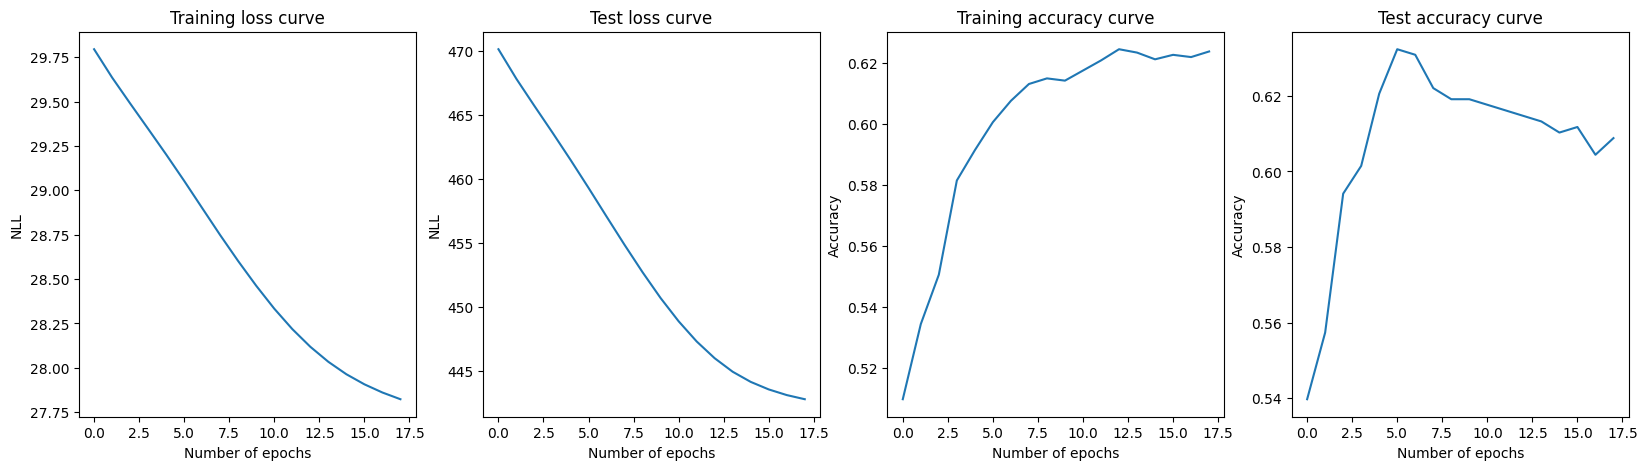

In [181]:
from matplotlib import pyplot

fig, axes = pyplot.subplots(ncols=4, figsize=(20, 5), sharey=False)

axes[0].set_xlabel('Number of epochs')
axes[0].set_ylabel('NLL')
axes[0].plot(range(0,len(train_losses)), train_losses)
axes[0].set_title('Training loss curve')

axes[1].set_xlabel('Number of epochs')
axes[1].set_ylabel('NLL')
axes[1].plot(range(0,len(train_losses)), test_losses)
axes[1].set_title('Test loss curve')

axes[2].set_xlabel('Number of epochs')
axes[2].set_ylabel('Accuracy')
axes[2].plot(range(0,len(train_losses)), list(map(lambda x : x/float(n_train), train_correct_list)))
axes[2].set_title('Training accuracy curve')

axes[3].set_xlabel('Number of epochs')
axes[3].set_ylabel('Accuracy')
axes[3].plot(range(0,len(train_losses)), list(map(lambda x : x/float(n_verify), test_correct_list)))
axes[3].set_title('Test accuracy curve')
pyplot.show()

In [182]:
def predict(distance, yard_line, seconds_remaining, score_differential):
    scaler = load('../models/scaler.joblib')
    data = scaler.transform([[yard_line, seconds_remaining, distance, score_differential]])[0]
    data_desc = data_as_string(data)
    return predict_from_model(data), data_desc
    

def predict_from_model(data):
    input_var = torch.tensor(data).float()
    ans = model(input_var)
    probs = torch.nn.functional.softmax(ans, dim=0)
    return float(probs[0])

def data_as_string(data):
    scaler = load('../models/scaler.joblib')
    scaled_data = scaler.inverse_transform([data])[0]
    score_dif = int(scaled_data[3])
    seconds_remaining = int(scaled_data[1])
    yards_to_go = int(scaled_data[2])
    yard_line = int(scaled_data[0])
    ans = f"4th down and {yards_to_go} on "
    if (yard_line < 50):
        ans += f"the {yard_line}"
    else:
        ans += f"their own {100 - yard_line}"
    ans += f" yard line, {seconds_remaining} seconds remaining, "
    if (score_dif < 0):
        ans += f"down by {-1 * score_dif}"
    elif (score_dif > 0):
        ans += f"up by {score_dif}"
    else:
        ans += "tie game."
    return ans

predict(1, 99, 300, 36)

/usr/local/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/var/folders/8r/q18lgzp95917cyrn8bqmq1c80000gn/T/ipykernel_37973/2536989008.py:25: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  y_output = self.log_softmax(x)


(0.5814898610115051,
 '4th down and 1 on their own 1 yard line, 300 seconds remaining, up by 36')